# Invoice Royalty and Product Revenue
## Run on Monday Afternoon after Melissa has run her the Invoice Entries
- Four Separte Tables are needed
- Have to merge the the four tables in order to get accurate report
- Always use the Invoice Date as a starting point in the InvoiceHistoryHeader

In [1]:
import pandas as pd
import os
import numpy as np
import pyodbc as odbc
import datetime as dt
from datetime import date,timedelta,datetime
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
import matplotlib.image as mpimg
os.chdir(r'G:\FinanceReports\2024\Wk47')
# plt.style.use('ggplot')

In [2]:
#Get Logo
img = mpimg.imread('Logo.png')

In [3]:
# # Make New Folder
os.mkdir(r'G:\FinanceReports\2024\Wk48')
# Change Directory
os.chdir(r'G:\FinanceReports\2024\Wk48')
# Add Logo to New Folder
plt.imsave('Logo.png', img)

In [4]:
os.getcwd()

'G:\\FinanceReports\\2024\\Wk48'

In [5]:
# Names the needed driver, server name, and database
driver_name='SQL Server'
server_name='10.0.1.127'
database='MAS_RFC'

In [6]:
#Creates the connection string
connection_string=f"""
DRIVER={{{driver_name}}};
SERVER={server_name};
DATABASE={database};
Trust_Connection=yes"""

In [7]:
connection=odbc.connect(connection_string)
print(connection)

In [8]:
# Four tables needed to run the report
# All four are needed in order run report
invoice_history=pd.read_sql_query("""SELECT * from MAS_RFC.dbo.AR_InvoiceHistoryHeader Where Year(InvoiceDate)>=2022""",connection)
customer=pd.read_sql_query('''select * from MAS_RFC.dbo.AR_Customer''',connection)
invoice_detail=pd.read_sql_query('''select InvoiceNo,ItemCode,ItemCodeDesc,ItemType,UnitPrice,QuantityShipped, UDF_ROYALTY_AMT,UDF_STD_UNIT_PRICE,ProductLine,CommentText from MAS_RFC.dbo.AR_InvoiceHistoryDetail''',connection)
product_line=pd.read_sql_query('''select * from MAS_RFC.dbo.IM_ProductLine''',connection)

C:\Users\jharned\AppData\Local\Temp\ipykernel_24456\1092709825.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  invoice_history=pd.read_sql_query("""SELECT * from MAS_RFC.dbo.AR_InvoiceHistoryHeader Where Year(InvoiceDate)>=2022""",connection)
C:\Users\jharned\AppData\Local\Temp\ipykernel_24456\1092709825.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customer=pd.read_sql_query('''select * from MAS_RFC.dbo.AR_Customer''',connection)
C:\Users\jharned\AppData\Local\Temp\ipykernel_24456\1092709825.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Pleas

# The Code Below Creates the Invoice DataFrame
- This is meant to replicate the Excel File of the Same Name
- The block below represents grabbing the certain columns we need, creating new columns Ext Base Cost and Ext Roylaty\
  merging the tables together and filtering out particular things we don't need
- Important to drop duplicated rows and keeping only the first duplicate

In [9]:
# Grabs the necessary columns from Invoice History
inv_hist=invoice_history[['CustomerNo','InvoiceNo','InvoiceType','ShipDate','InvoiceDate','BillToState','InvoiceDueDate']]
# Merges Invoice History with Invoice Detail on InvoiceNo column
inv_merge=inv_hist.merge(invoice_detail,on='InvoiceNo',how='inner').drop_duplicates(keep='first')
inv_merge['Ext Base Cost']=inv_merge.QuantityShipped*inv_merge.UDF_STD_UNIT_PRICE
inv_merge['Ext Royalty']=inv_merge.QuantityShipped*inv_merge.UDF_ROYALTY_AMT
cust=customer[['CustomerNo','CustomerName','City','ARDivisionNo','UDF_ROYALTY_METHOD','UDF_DISTRIBUTOR']]
all_merge=inv_merge.merge(cust,on='CustomerNo',how='inner').drop_duplicates(keep='first')
filtered=all_merge[all_merge.ARDivisionNo=='01']
# filtered=all_merge[(all_merge.ItemType=='1')&(all_merge.ARDivisionNo=='01')]
total_df=filtered.merge(product_line[['ProductLine','ProductLineDesc']],on='ProductLine').drop_duplicates(keep='first')
total_df=total_df[total_df.InvoiceDate.dt.year<=2024]
total_df=total_df[(total_df.CustomerNo!='TRAINMS')&(total_df.CustomerNo!='EAGLES1')&(total_df.CustomerNo!='CANA001')]
total_df.loc[total_df.CustomerNo==1528,'BillToState']='PA'
state=['PA','NJ','DE','MD']

In [10]:
total_df.shape

(1240683, 24)

In [11]:
# Names the needed driver, server name, and database
driver_name='SQL Server'
server_name='10.0.1.218'
database='ritascoolnet_live'
#Creates the connection string
connection_string=f"""
DRIVER={{{driver_name}}};
SERVER={server_name};
DATABASE={database};
Trust_Connection=yes"""
#Creates the Connection to SQL Server
connection=odbc.connect(connection_string)
print(connection)

In [12]:
# Pulls Marketing info needed like Coolnet Group, MSA, and DMA
data=pd.read_sql_query('''Select intstoreid as intStoreID,RitasID, FC,CoolNetGroup,LegacyStoreType,State,MSAName,DMA,StoreName as ShopName,CoOpName,OpenDate,StoreStatus,[Re Open Date] as ReOpenDate from ritascoolnet_live.dbo.vShopDetail''',
                        connection)
relo=pd.read_sql_query('''Select intStoreID,dteClosedForRelocation,intParentStoreID as ParentID,
intRitasStoreID as CustomerNo,bitDriveThru as DT from ritascoolnet_live.dbo.GOOGLE_MAP_store''',connection)
data=data.merge(relo[['intStoreID','dteClosedForRelocation']],on='intStoreID',how='left')
data=data.sort_values(by='intStoreID',ascending=False).drop_duplicates(subset='RitasID',keep='first')
data=data.rename(columns={'RitasID':'CustomerNo'})
data['dteClosedForRelocation']=pd.to_datetime(data['dteClosedForRelocation'])
data['Days']=(data.ReOpenDate-data.dteClosedForRelocation).dt.days
data['OpenDate']=np.where(data.Days>=365,data.ReOpenDate,data.OpenDate)

C:\Users\jharned\AppData\Local\Temp\ipykernel_24456\4141677903.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data=pd.read_sql_query('''Select intstoreid as intStoreID,RitasID, FC,CoolNetGroup,LegacyStoreType,State,MSAName,DMA,StoreName as ShopName,CoOpName,OpenDate,StoreStatus,[Re Open Date] as ReOpenDate from ritascoolnet_live.dbo.vShopDetail''',
C:\Users\jharned\AppData\Local\Temp\ipykernel_24456\4141677903.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  relo=pd.read_sql_query('''Select intStoreID,dteClosedForRelocation,intParentStoreID as ParentID,


In [13]:
data

intStoreID  CustomerNo              FC         CoolNetGroup  \
4466        5582      1588.0    Emily Little             DE Minio   
4465        5581       247.0    Joe Toocheck            PA Zilner   
4464        5580     11518.0     Dave Roemer      NC Kovesi-Miara   
4463        5579      1587.0     Dave Roemer   SC Reichard-Fariss   
4462        5578      5039.0    Jamie Snyder  INT Philippines Ang   
...          ...         ...             ...                  ...   
13            39    100228.0  Paul Greenberg            OH Lawson   
11            37      1542.0     Dave Roemer    OH Siebzener-Wolf   
7             32       821.0            None          OH Williams   
6             29      1570.0  Paul Greenberg            OH Lawson   
1             24       774.0            None           VA Manassa   

        LegacyStoreType State                     MSAName         DMA  \
4466  Walk-in / Walk-up    MD                        None        None   
4465            Walk-up    PA                  Pittsburgh  Pittsburgh   
4464             Mobile    NC  Charlotte-Concord-Gastonia   Charlotte   
4463  Walk-in / Walk-up    SC                        None        None   
4462               Mall                              None        None   
...                 ...   ...                         ...         ...   
13    Walk-in / Walk-up    OH                        None        None   
11              Walk-up    OH                        None        None   
7                  None    OH                        None        None   
6     Walk-in / Walk-up    OH                        None        None   
1                  None    VA                        None        None   

                                      ShopName CoOpName   OpenDate  \
4466         12630 Ocean Gateway-Ocean City MD     None        NaT   
4465           2070 Greentree Rd-Pittsburgh PA     None 2001-04-17   
4464                   Mooresville NC (Mobile)     None 2023-10-11   
4463                                 Easley SC     None        NaT   
4462                   Venice Grand Canal Mall     None        NaT   
...                                        ...      ...        ...   
13                Greater Cincinnati OH Loc. 2     None        NaT   
11    1976 Warrensville Cnt Rd-South Euclid OH     None 2024-11-13   
7                        Ohio State University     None        NaT   
6                 Greater Cincinnati OH Loc. 1     None        NaT   
1                                    Arlington     None        NaT   

      StoreStatus ReOpenDate dteClosedForRelocation  Days  
4466  Coming Soon        NaT                    NaT   NaN  
4465         Open        NaT                    NaT   NaN  
4464      Sold!!!        NaT                    NaT   NaN  
4463      Sold!!!        NaT                    NaT   NaN  
4462  Coming Soon        NaT                    NaT   NaN  
...           ...        ...                    ...   ...  
13        Sold!!!        NaT                    NaT   NaN  
11           Open        NaT                    NaT   NaN  
7      Terminated        NaT                    NaT   NaN  
6         Sold!!!        NaT                    NaT   NaN  
1      Terminated        NaT                    NaT   NaN  

[2565 rows x 15 columns]

In [14]:
total_df.shape

(1240683, 24)

In [15]:
#This adds the OpenDate to the Total_Df dataframe. There is some minor manipulation done in order to merge the OpenDate
#with the the Total_Df

total_df['CustomerNo']=total_df.CustomerNo.astype('int')
total_df=total_df.merge(data[['CustomerNo','OpenDate','StoreStatus']],on='CustomerNo',how='left')
total_df['OpenDate']=total_df.OpenDate.fillna('No Open Date')
total_df['OpenDate']=pd.to_datetime(total_df['OpenDate'],errors='coerce')
total_df.OpenDate.replace({pd.NaT: 'No Open Date'}, inplace=True)
total_df.loc[total_df.CustomerNo==1528,'BillToState']='PA'
total_df.loc[total_df.CustomerNo==1446,'BillToState']='PA'
total_df.loc[total_df.CustomerNo==1468,'BillToState']='MD'
total_df.loc[total_df.CustomerNo==1515,'BillToState']='AL'
total_df.loc[total_df.CustomerNo==1397,'BillToState']='AL'
total_df.loc[total_df.CustomerNo==1337,'BillToState']='FL'

In [16]:
total_df.shape

(1240683, 26)

# The next several lines of code are merely visualizations of the Invoice Date and are not part of the Invoice Report

In [17]:
#Type in the Month you wish to view
month=input('Enter Desired Month to View: ')

Enter Desired Month to View: November


C:\Users\jharned\AppData\Local\Temp\ipykernel_24456\2364127482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)


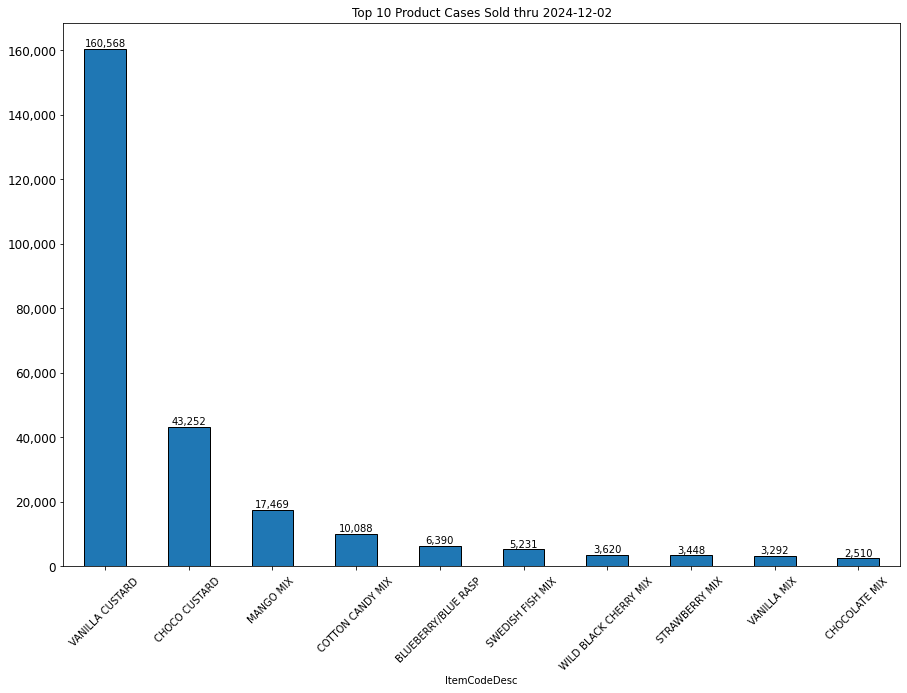

In [18]:
# Top 10 Product Sold YTD based on Today's Date
mixes=['CUSTARD','MIXES','CUSTARD - KOSHER','MIXES-SUGARFREE']
total_df['ItemCodeDesc']=total_df.ItemCodeDesc.str.split('(').str[0]
ax=total_df[total_df.ProductLineDesc.isin(mixes)&(total_df.InvoiceDate.dt.year==2024)].groupby(
    ['ItemCodeDesc'])['QuantityShipped'].sum().nlargest(10).plot(
kind='bar',figsize=(15,10),title='Top 10 Product Cases Sold thru '+str(date.today()),edgecolor='black')
ax.bar_label(ax.containers[0],fmt='{:,.0f}')
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)
ax.yaxis.set_major_formatter('{:,.0f}'.format)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

In [19]:
mix=total_df[total_df.ProductLineDesc.isin(mixes)].groupby('ItemCodeDesc')['Ext Royalty'].sum().sort_values(ascending=False)
mix/mix.sum()*100

ItemCodeDesc
VANILLA CUSTARD                   37.715707
CHOCO CUSTARD                     10.488772
MANGO MIX                          9.647699
COTTON CANDY MIX                   5.320401
CHERRY MIX                         4.517228
BLUEBERRY/BLUE RASP                3.557347
LEMON BASE                         3.048219
SWEDISH FISH MIX                   2.927844
WILD BLACK CHERRY MIX              2.039055
STRAWBERRY MIX                     1.998774
CHOCOLATE MIX                      1.388412
ROOT BEER MIX                      1.370685
WATERMELON MIX                     1.300472
VANILLA MIX                        1.292335
GREEN APPLE                        1.220246
NEW GEORGIA PEACH MIX              1.094540
MINT CHOC CHIP CRM MIX             0.982954
PINA COLADA MIX                    0.850202
ISLAND FUSION MIX                  0.758352
COOKIES N' CREAM MIX               0.606735
FLORIDA ORANGE MIX                 0.599526
PINEAPPLE MIX                      0.598399
SOUR PATCH KIDS MIX

In [20]:
vol_price=total_df[(total_df.InvoiceDate.dt.year>=2023)&(total_df.InvoiceDate.dt.month<=11)&(total_df.ProductLineDesc.isin(mixes))]\
.pivot_table(index=['ItemCodeDesc'],columns=[total_df.InvoiceDate.dt.year],values=['UDF_STD_UNIT_PRICE','QuantityShipped'],
                                                                aggfunc={'UDF_STD_UNIT_PRICE':'median',
                                                                         'QuantityShipped':'sum'},fill_value=0)
vol_price.columns = ['_'.join(map(str, col)).strip() for col in vol_price.columns]
vol_price['Revenue_23']=round(vol_price.iloc[:,0]*vol_price.iloc[:,2],2)
vol_price['Revenue_24']=round(vol_price.iloc[:,1]*vol_price.iloc[:,3],2)
vol_price['Chng_Rev']=vol_price.iloc[:,-1]-vol_price.iloc[:,-2]
vol_price.sort_values('Chng_Rev')

QuantityShipped_2023  QuantityShipped_2024  \
ItemCodeDesc                                                                 
GUMMY BEAR MIX                               1300.00                 -1.00   
CHOCO CUSTARD                               42866.50              43220.00   
TROPICAL PUNCH MIX                            556.00                 13.00   
NEW GEORGIA PEACH MIX                        2293.75               1669.42   
SOUR PATCH KIDS MIX                          1430.00                812.95   
GRAPE MIX                                     281.00                  2.00   
RASPBERRY MIX                                 530.50                383.25   
DR.PEPPER MIX                                 465.00                285.75   
UNICORN MIX                                   683.50                469.00   
JUICY PEAR MIX                                889.25                641.75   
WATERMELON MIX                               2413.25               1986.75   
BIRTHDAY CAKE MIX                             559.25                364.75   
BANANA MIX                                    940.50                708.00   
GUAVA PASSION FRUIT MIX -4/1 G                 99.50                  0.00   
OATLY VANILLA SOFT SERVE                       83.00                  0.00   
VANILLA CUSTARD                            153588.00             160513.50   
TANGERINE MIX                                  21.25                  0.00   
CITRUS BLAST MIX                                5.00                  0.00   
KLEINS CHOCO CUSTARD                          432.00                 85.00   
KLEINS VANILLA CUSTARD                       1486.00                251.00   
2.5 GAL CHOCO CUST CREDIT                     -18.00                -16.00   
2.5 GAL VANILLA CUST CREDIT                   -47.00                -38.00   
PINEAPPLE MIX                                1074.50               1005.25   
PINA COLADA MIX                              1483.00               1320.75   
S'MORES MIX                                   603.25                609.00   
COCONUT CREAM MIX                            1026.00                955.00   
STRAWBERRY MIX                               3582.50               3448.25   
PUMPKIN MIX                                   290.00                316.00   
MINT CHOC CHIP CRM MIX                        842.12                814.00   
OCEAN SPLASH                                  294.00                319.00   
GREEN APPLE                                  2213.75               2166.00   
SWEDISH FISH MIX                             5469.75               5231.25   
CANTALOUPE MIX                                126.00                252.00   
CHOCOLATE MIX                                2512.50               2510.00   
ISLAND FUSION MIX                            1434.00               1406.75   
CHERRY MIX                                   2152.00               2188.00   
KEY LIME MIX                                  400.50                604.75   
CHEESECAKE MIX                                296.00                422.75   
BLUEBERRY/BLUE RASP                          6507.50               6389.50   
WILD BLACK CHERRY MIX                        3629.75               3619.50   
FLORIDA ORANGE MIX                           1123.77                972.17   
ROOT BEER MIX                                2553.25               2503.75   
LEMON BASE                                   1105.00               1372.75   
CY POWDER CHOCO CUSTARD                         0.00                181.00   
COTTON CANDY MIX                             9843.75              10087.75   
COOKIES N' CREAM MIX                          849.75               1284.75   
KOSHER POWDERED CHOC CUST                       0.00                247.00   
VANILLA MIX                                  2764.75               3292.00   
NERDS MIX                                       0.00               1372.25   
CY POWDER VANILLA CUSTARD                       0.00  

C:\Users\jharned\AppData\Local\Temp\ipykernel_24456\1541036762.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=15)


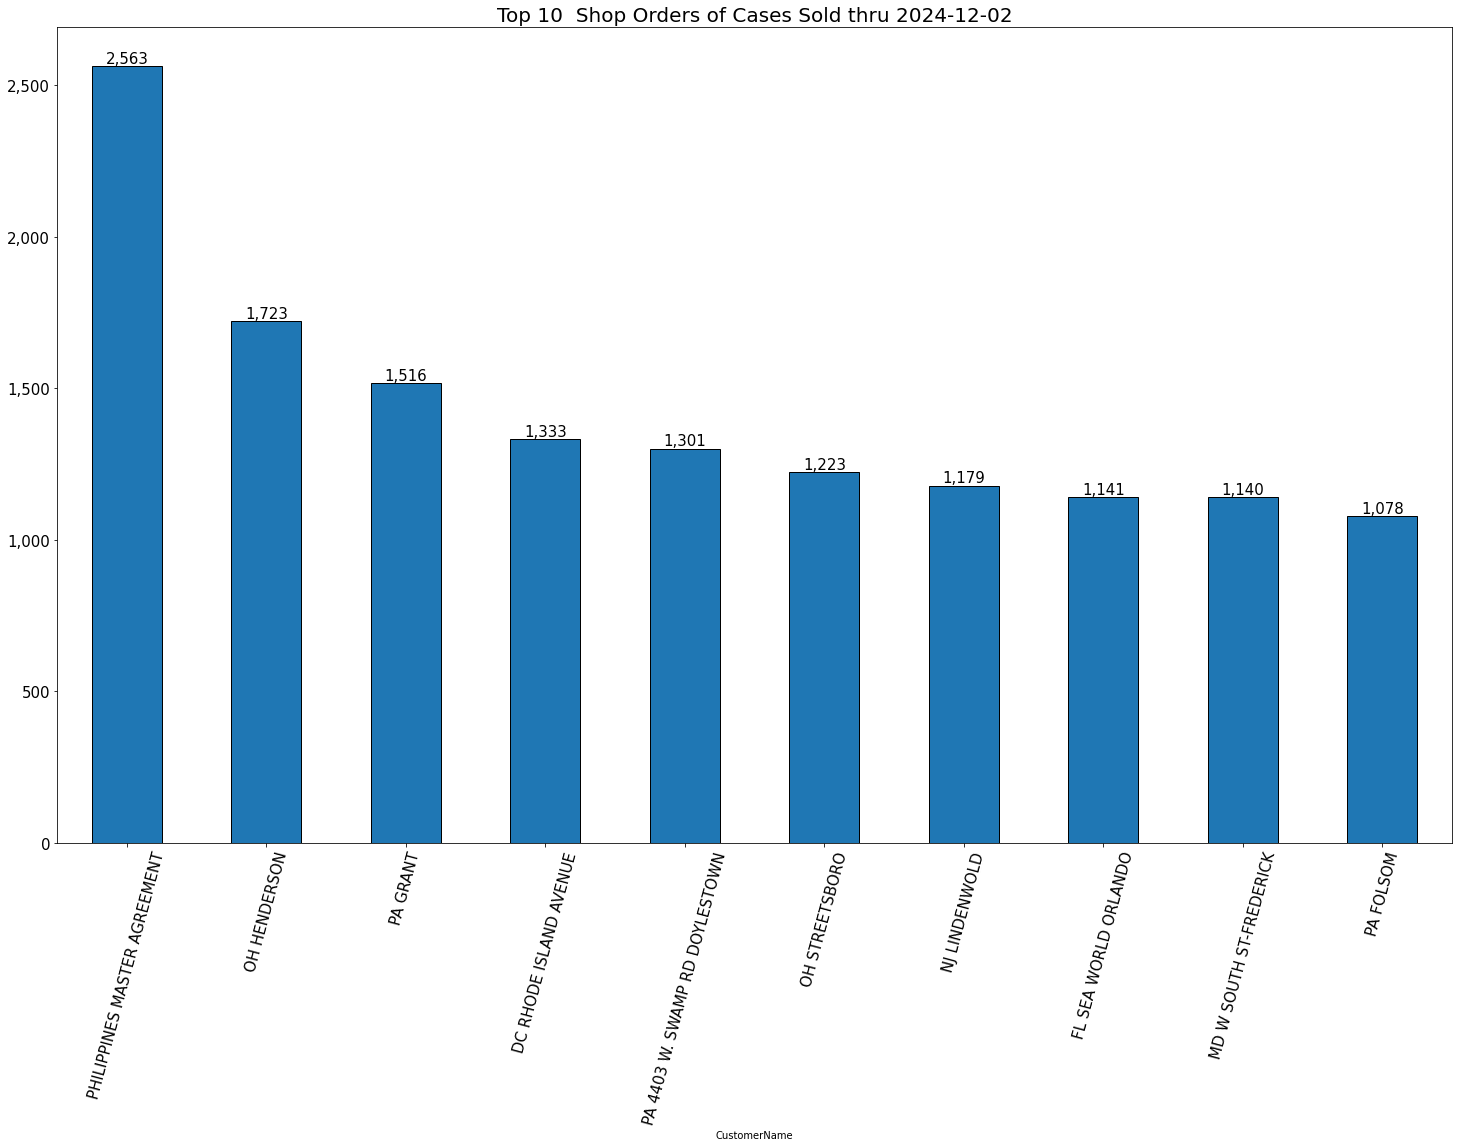

In [21]:
# Top 10 Shops who have ordered the most cases

ax=total_df[(total_df.ProductLineDesc.isin(mixes))&(total_df.InvoiceDate.dt.year==2024)].groupby(
    ['CustomerName'])['QuantityShipped'].sum().nlargest(10).plot(
kind='bar',figsize=(25,15),title='Top 10  Shop Orders of Cases Sold thru '+str(date.today()),edgecolor='black')
ax.bar_label(ax.containers[0],fontsize=15,fmt='{:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=75,fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=15)
ax.yaxis.set_major_formatter('{:,.0f}'.format)
ax.set_title('Top 10  Shop Orders of Cases Sold thru '+str(date.today()),fontsize=20);

C:\Users\jharned\AppData\Local\Temp\ipykernel_24456\472647877.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45);


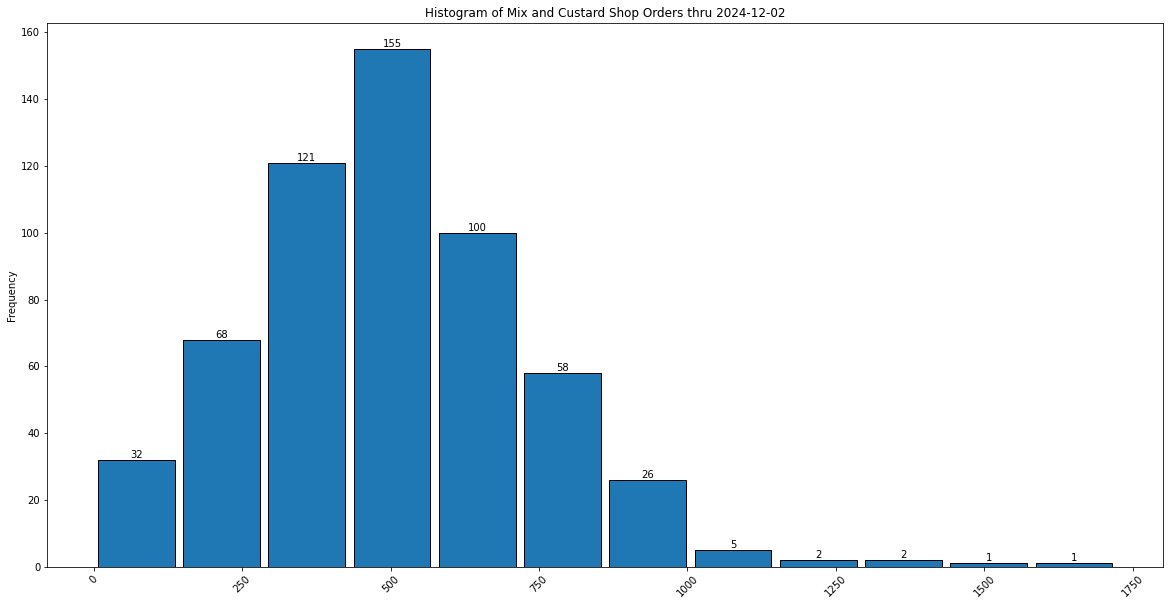

In [22]:
# Distribution of Shop Orders
ax=total_df[(total_df.ProductLineDesc.isin(mixes))&(total_df.InvoiceDate.dt.year==2024)&~(total_df.CustomerName.str.contains("PHILIP"))].groupby(
    ['CustomerName'])['QuantityShipped'].sum().plot(
kind='hist',figsize=(20,10),title='Histogram of Mix and Custard Shop Orders thru '+str(date.today()),bins=12,rwidth=.9,
edgecolor='black')
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

C:\Users\jharned\AppData\Local\Temp\ipykernel_24456\843335372.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45);


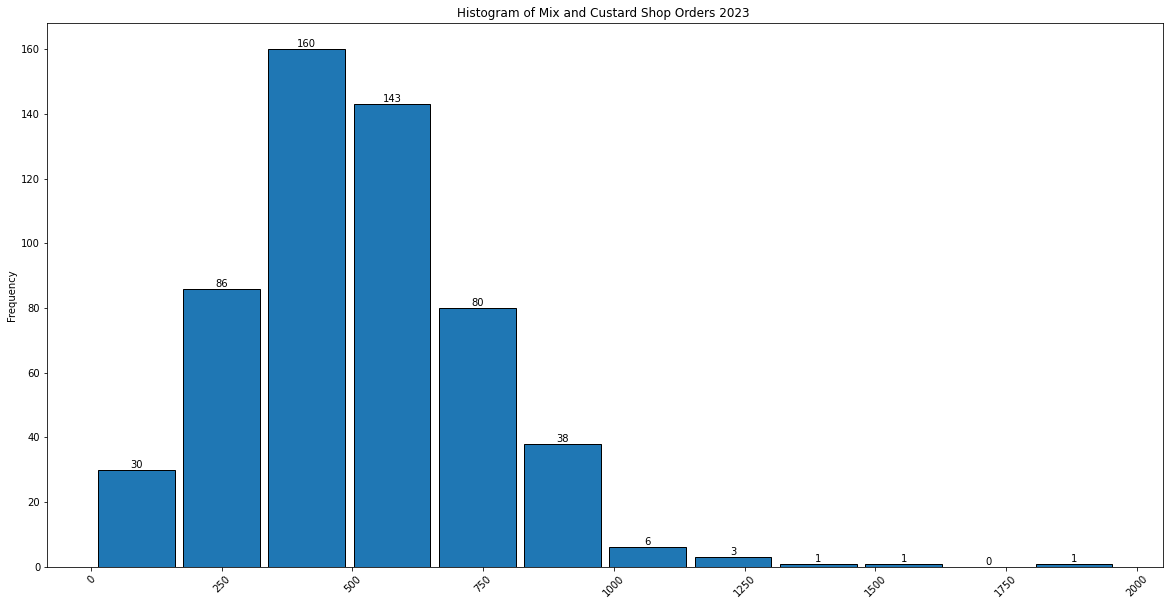

In [23]:
ax=total_df[(total_df.ProductLineDesc.isin(mixes))&(total_df.InvoiceDate.dt.year==2023)&~(total_df.CustomerName.str.contains("PHILIP"))].groupby(
    ['CustomerName'])['QuantityShipped'].sum().plot(
kind='hist',figsize=(20,10),title='Histogram of Mix and Custard Shop Orders 2023 ',bins=12,rwidth=.9,
edgecolor='black')
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

In [24]:
# Desription of the Histogram above
total_df[(total_df.ProductLineDesc.isin(mixes))&(total_df.InvoiceDate.dt.year==2023)&~(total_df.CustomerName.str.contains("PHILIP"))].groupby(
    ['CustomerName'])['QuantityShipped'].sum().describe()

count     549.000000
mean      513.945155
std       237.041426
min         5.000000
25%       356.000000
50%       493.000000
75%       648.000000
max      1962.000000
Name: QuantityShipped, dtype: float64

In [25]:
# test=total_df[(total_df.ProductLineDesc.isin(mixes))&~(total_df.CustomerName.str.contains("PHILIP"))].groupby(
#     ['CustomerName','Year'])['QuantityShipped'].sum().reset_index()
# sns.histplot(data=test[test.Year==2024],x='QuantityShipped',color='#C12637',bins=10,alpha=.5,label='2024')
# sns.histplot(data=test[test.Year==2023],x='QuantityShipped',color='#12703C',bins=10,alpha=.5,label='2023')
# plt.legend(loc='upper right')


In [26]:
# Desription of the Histogram above
total_df[(total_df.ProductLineDesc.isin(mixes))&(total_df.InvoiceDate.dt.year==2024)&~(total_df.CustomerName.str.contains("PHILIP"))].groupby(
    ['CustomerName'])['QuantityShipped'].sum().describe()

count     571.000000
mean      501.328004
std       237.164683
min         0.000000
25%       345.000000
50%       490.000000
75%       639.835000
max      1723.000000
Name: QuantityShipped, dtype: float64

In [27]:
qs=total_df[(total_df.ProductLineDesc.isin(mixes))&(total_df.InvoiceDate.dt.year==2024)&~(total_df.CustomerName.str.contains("PHILIP"))].groupby(
    ['CustomerName'])['QuantityShipped'].sum().reset_index()
qs[qs.QuantityShipped>(qs.QuantityShipped.mean()+(qs.QuantityShipped.std()*2))].sort_values(by='QuantityShipped',ascending=False)

CustomerName  QuantityShipped
336                    OH HENDERSON          1723.00
443                        PA GRANT          1516.00
35           DC RHODE ISLAND AVENUE          1333.00
374  PA 4403 W. SWAMP RD DOYLESTOWN          1300.75
339                  OH STREETSBORO          1223.00
263                   NJ LINDENWOLD          1179.00
86             FL SEA WORLD ORLANDO          1141.00
182         MD W SOUTH ST-FREDERICK          1140.00
436                       PA FOLSOM          1078.00
124  MD 8900 BALTIMORE-COLLEGE PARK          1039.00
55    FL 1010 COURT ST - CLEARWATER          1033.00
306                     NJ VOORHEES          1004.00
561   VA BUSCH GARDENS WILLIAMSBURG           991.00
151                   MD HAGERSTOWN           983.00

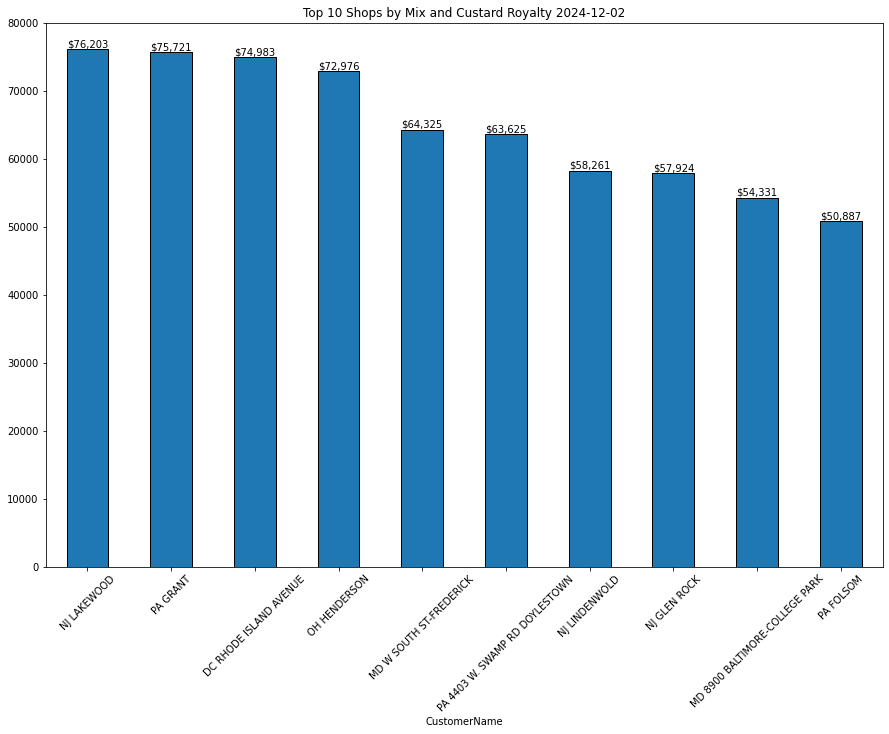

In [28]:
# Top 10 Shops Based on Royalty paid in Mixes and Custard YTD
ax=total_df[(total_df.ProductLineDesc.isin(mixes))&(total_df.InvoiceDate.dt.year==2024)].groupby(
    ['CustomerName'])['Ext Royalty'].sum().nlargest(10).plot(
kind='bar',figsize=(15,10),title='Top 10 Shops by Mix and Custard Royalty '+str(date.today()),edgecolor='black')
ax.bar_label(ax.containers[0],fmt='${:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

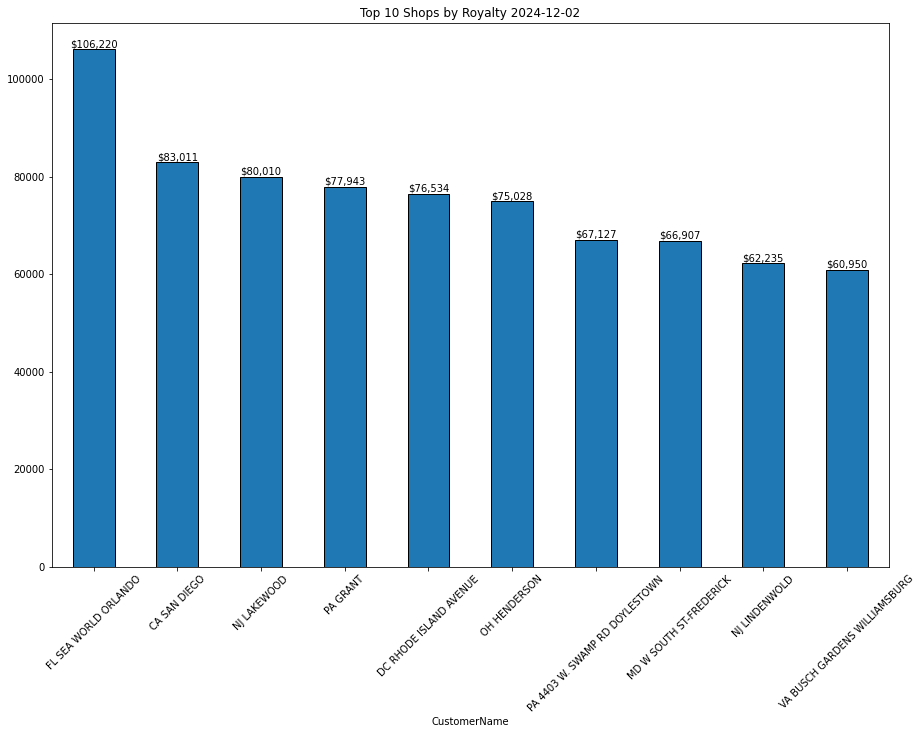

In [29]:
# Top 10 Shops in Total Royalty Paid YTD
ax=total_df[(total_df.InvoiceDate.dt.year==2024)].groupby(
    ['CustomerName'])['Ext Royalty'].sum().nlargest(10).plot(
kind='bar',figsize=(15,10),title='Top 10 Shops by Royalty '+str(date.today()),edgecolor='black')
ax.bar_label(ax.containers[0],fmt='${:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

In [30]:
total_df[(total_df.InvoiceDate.dt.year==2024)].groupby(
    ['CustomerName'])['Ext Royalty'].sum().describe()

count       592.000000
mean      25020.165146
std       13334.024594
min         -22.860000
25%       16930.440000
50%       24635.325000
75%       32070.200000
max      106220.320000
Name: Ext Royalty, dtype: float64

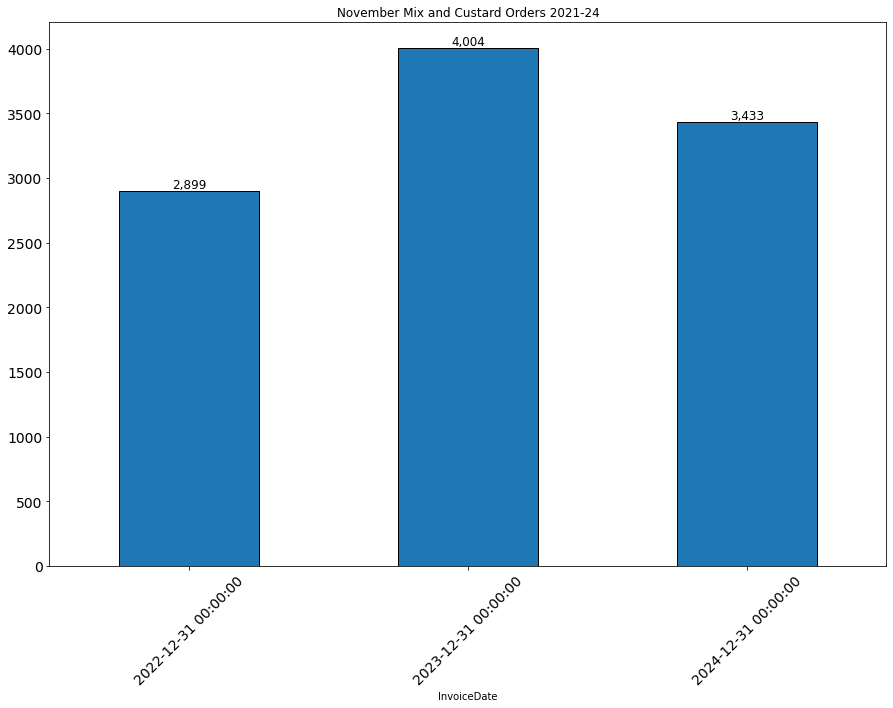

In [31]:
# Current Month Mix and Custard orders by Year
ax=total_df[(total_df.InvoiceDate.dt.strftime('%B')==month)&(total_df.ProductLineDesc.isin(mixes))].groupby(
    pd.Grouper(key='InvoiceDate',freq='Y'))['QuantityShipped'].sum().plot(
    kind='bar',edgecolor='black',figsize=(15,10),title=str(month)+' Mix and Custard Orders 2021-24',
fontsize=14)
ax.bar_label(ax.containers[0],fontsize=12,fmt='{:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

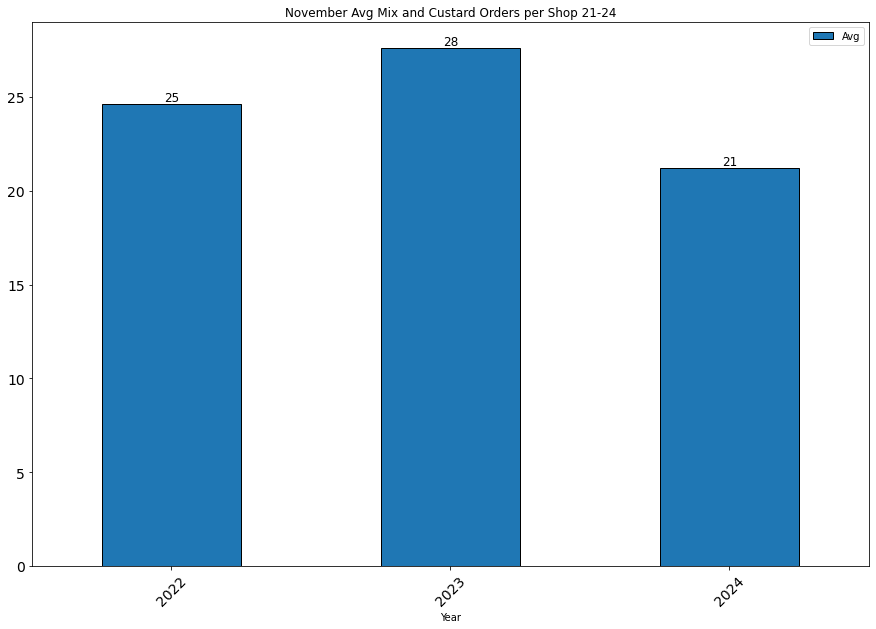

In [32]:
#Current Month Avg Mix and Custard order by Shop by Year
df=total_df[(total_df.InvoiceDate.dt.strftime('%B')==month)&(total_df.ProductLineDesc.isin(mixes))].groupby(
    pd.Grouper(key='InvoiceDate',freq='Y'))[['CustomerNo','QuantityShipped']].agg({
        'CustomerNo':'nunique',
        'QuantityShipped':'sum'
    }).reset_index()
df['Avg']=round(df.iloc[:,-1].div(df.iloc[:,-2]),1)
df['Year']=df.InvoiceDate.dt.year
ax=df.plot(kind='bar',x='Year',y='Avg',edgecolor='black',
       figsize=(15,10),title=str(month)+' Avg Mix and Custard Orders per Shop 21-24',fontsize=14)
ax.bar_label(ax.containers[0],fontsize=12,fmt='{:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

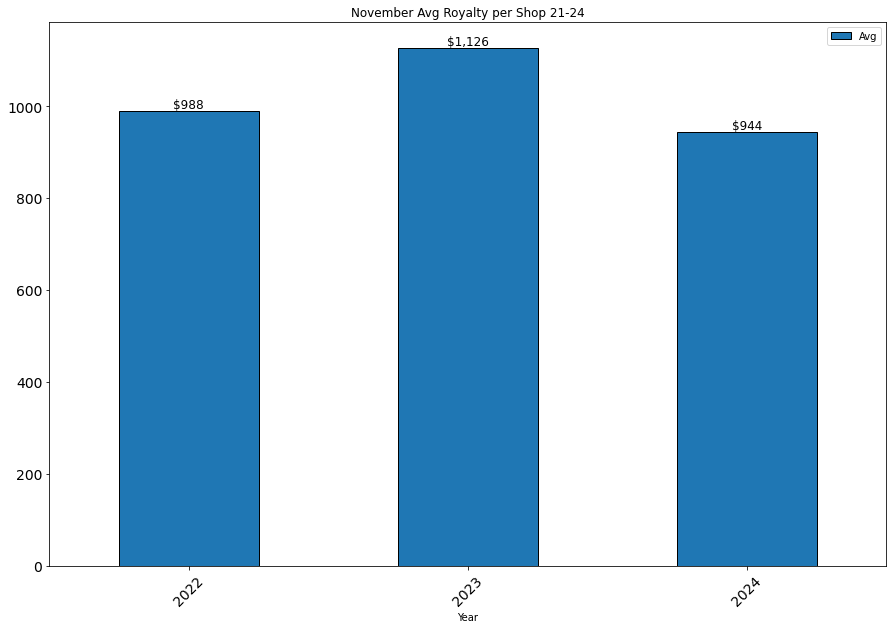

In [33]:
# Current Month Avg Royalty per Shop by Year
df=total_df[(total_df.InvoiceDate.dt.strftime('%B')==month)&(total_df.ProductLineDesc.isin(mixes))].groupby(
    pd.Grouper(key='InvoiceDate',freq='Y'))[['CustomerNo','Ext Royalty']].agg({
        'CustomerNo':'nunique',
        'Ext Royalty':'sum'
    }).reset_index()
df['Avg']=round(df.iloc[:,-1].div(df.iloc[:,-2]),1)
df['Year']=df.InvoiceDate.dt.year
ax=df.plot(kind='bar',x='Year',y='Avg',edgecolor='black',
       figsize=(15,10),title=str(month)+' Avg Royalty per Shop 21-24',fontsize=14)
ax.bar_label(ax.containers[0],fontsize=12,fmt='${:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

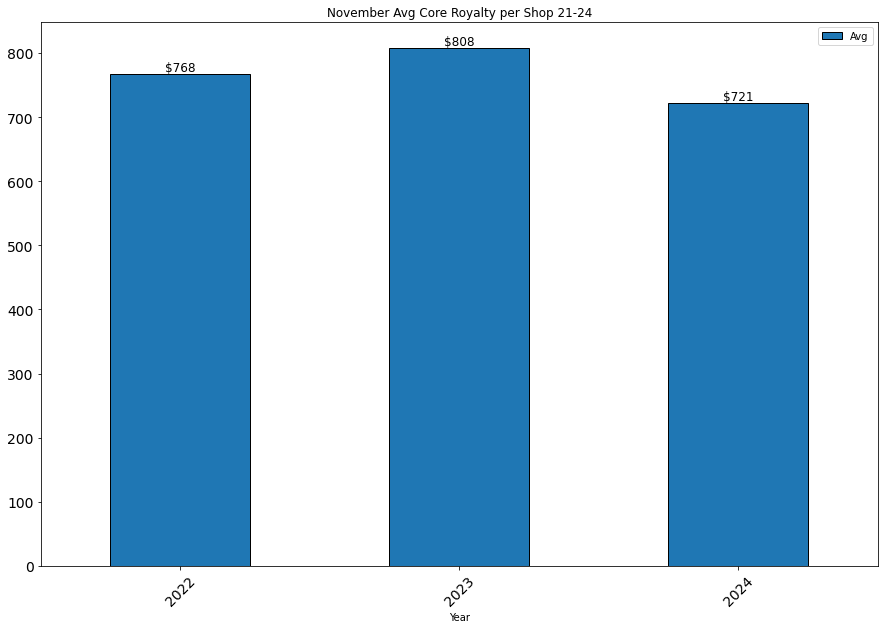

In [34]:
# Current Month Core Shop Royalty by Month by Year
df=total_df[(total_df.InvoiceDate.dt.strftime('%B')==month)&(total_df.ProductLineDesc.isin(mixes))&(
total_df.BillToState.isin(state))].groupby(
    pd.Grouper(key='InvoiceDate',freq='Y'))[['CustomerNo','Ext Royalty']].agg({
        'CustomerNo':'nunique',
        'Ext Royalty':'sum'
    }).reset_index()
df['Avg']=round(df.iloc[:,-1].div(df.iloc[:,-2]),1)
df['Year']=df.InvoiceDate.dt.year
ax=df.plot(kind='bar',x='Year',y='Avg',edgecolor='black',
       figsize=(15,10),title=str(month)+' Avg Core Royalty per Shop 21-24',fontsize=14)
ax.bar_label(ax.containers[0],fontsize=12,fmt='${:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

In [35]:
df

InvoiceDate  CustomerNo  Ext Royalty    Avg  Year
0  2022-12-31          43   33005.6400  767.6  2022
1  2023-12-31          57   46026.2550  807.5  2023
2  2024-12-31          57   41120.9725  721.4  2024

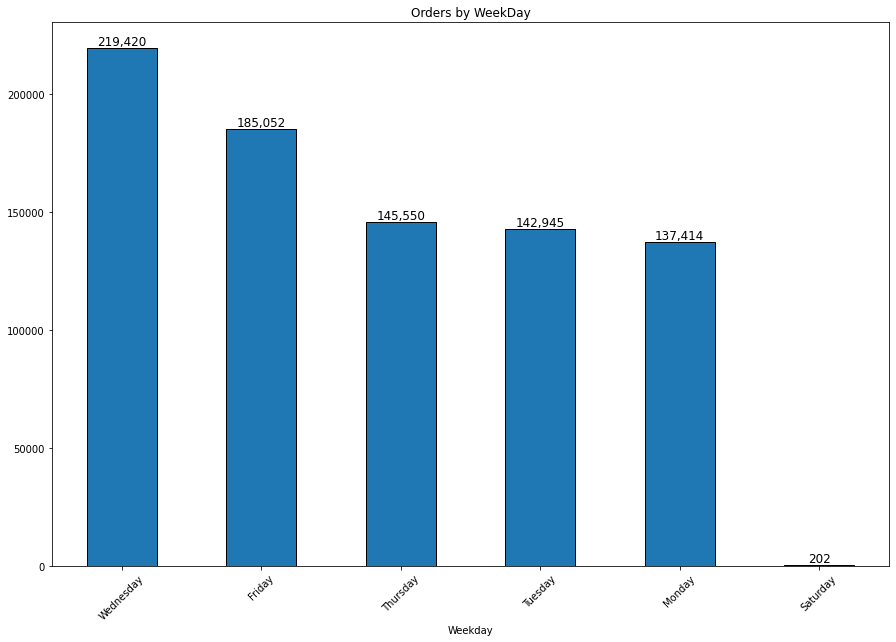

In [36]:
# Orders by Week Day
total_df['Weekday']=total_df.InvoiceDate.dt.strftime('%A')
ax=total_df[total_df.ProductLineDesc.isin(mixes)].groupby('Weekday')['QuantityShipped'].sum().sort_values(ascending=False).plot(
    kind='bar',title='Orders by WeekDay',edgecolor='black',
figsize=(15,10))
ax.bar_label(ax.containers[0],fontsize=12,fmt='{:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

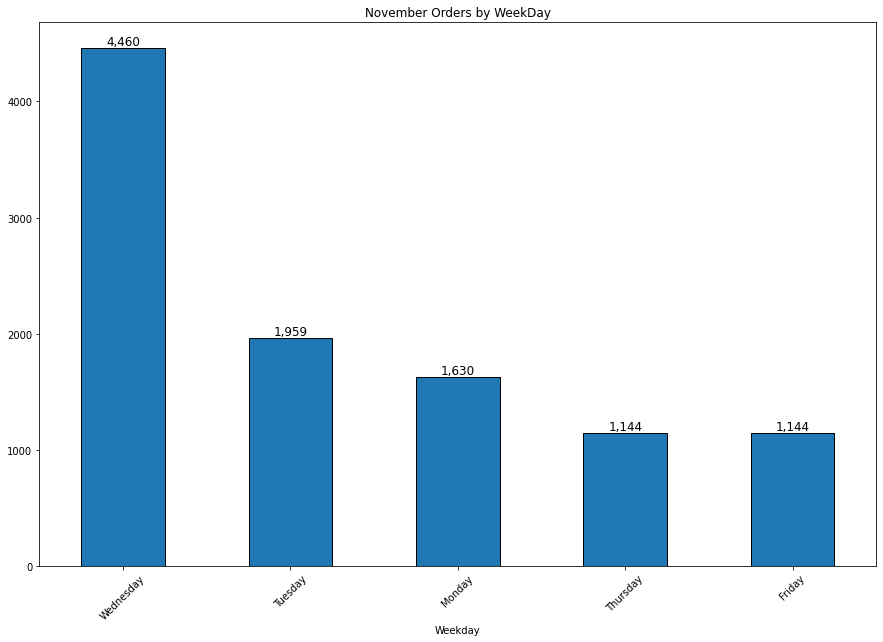

In [37]:
# Current Month Orders by Week Day
ax=total_df[total_df.ProductLineDesc.isin(mixes)&(total_df.InvoiceDate.dt.strftime('%B')==month)].groupby('Weekday')['QuantityShipped'].sum().sort_values(ascending=False).plot(
    kind='bar',title=str(month)+' Orders by WeekDay',edgecolor='black',
figsize=(15,10))
ax.bar_label(ax.containers[0],fontsize=12,fmt='{:,.0f}')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

<Axes: xlabel='InvoiceDate'>

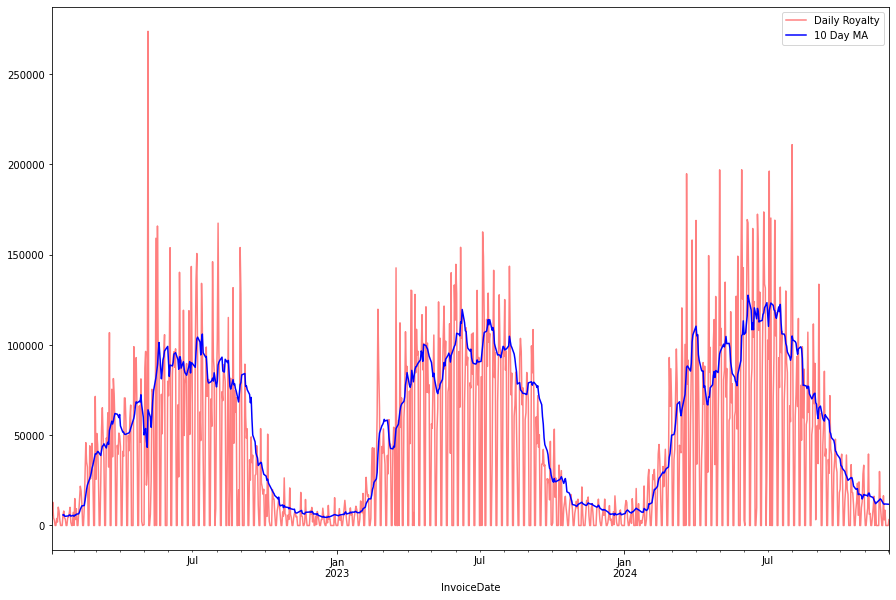

In [38]:
total_df[total_df.InvoiceDueDate.dt.year>=2020].groupby(pd.Grouper(key='InvoiceDate',freq='D'))['Ext Royalty']\
.sum().plot(figsize=(15,10),color='red',label='Daily Royalty',legend=['Daily Royalty'],alpha=.5)
total_df[total_df.InvoiceDueDate.dt.year>=2020].groupby('InvoiceDate')['Ext Royalty'].sum().rolling(10).mean()\
.plot(figsize=(15,10),color='blue',label='10 Day MA',legend=['10 Day MA'])


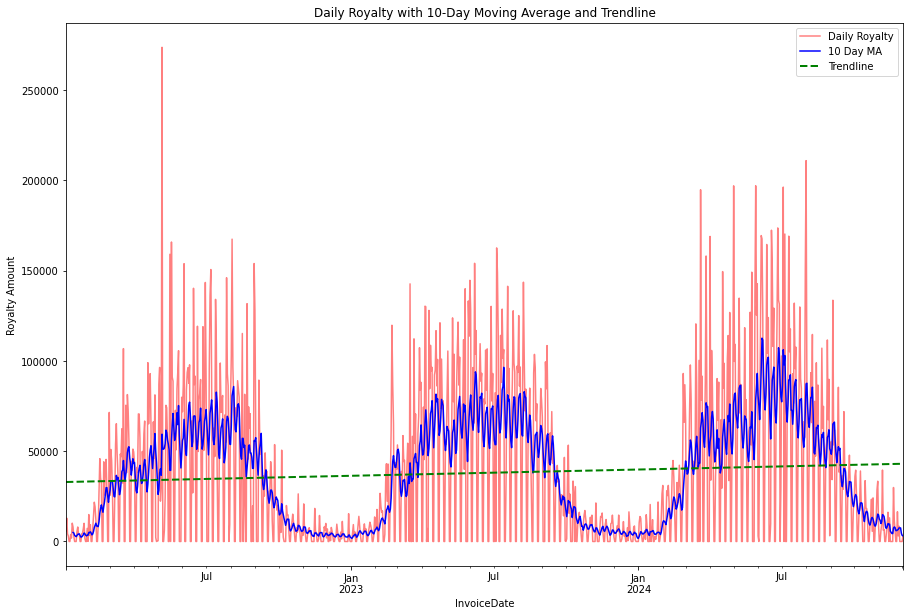

In [39]:

# Filter and group data
daily_data = total_df[total_df.InvoiceDueDate.dt.year >= 2020].groupby(pd.Grouper(key='InvoiceDate', freq='D'))['Ext Royalty'].sum()
rolling_data = daily_data.rolling(10).mean()

# Plot Daily Royalty and 10 Day Moving Average
fig, ax = plt.subplots(figsize=(15, 10))
daily_data.plot(ax=ax, color='red', label='Daily Royalty', alpha=0.5)
rolling_data.plot(ax=ax, color='blue', label='10 Day MA')

# Add Trendline
# Convert dates to a numerical format (e.g., days since start) for polyfit
x_numeric = (daily_data.index - daily_data.index[0]).days
trend = np.polyfit(x_numeric, daily_data.values, 1)  # Linear trendline (degree=1)
trendline = np.polyval(trend, x_numeric)

# Plot the trendline
ax.plot(daily_data.index, trendline, color='green', linestyle='--', linewidth=2, label='Trendline')

# Final adjustments
ax.legend()
ax.set_ylabel('Royalty Amount')
ax.set_title('Daily Royalty with 10-Day Moving Average and Trendline')
plt.show()

In [40]:
rolling=total_df.groupby('InvoiceDate')['QuantityShipped'].sum().rolling(30).mean().reset_index()
rolling['Year']=rolling.InvoiceDate.dt.year
find=rolling.groupby('Year')['QuantityShipped'].max()
max_year=rolling[rolling.QuantityShipped.isin(find)]

In [41]:
max_year

InvoiceDate  QuantityShipped  Year
133  2022-07-14      4975.957333  2022
375  2023-07-10      5157.745067  2023
627  2024-07-15      5385.007667  2024

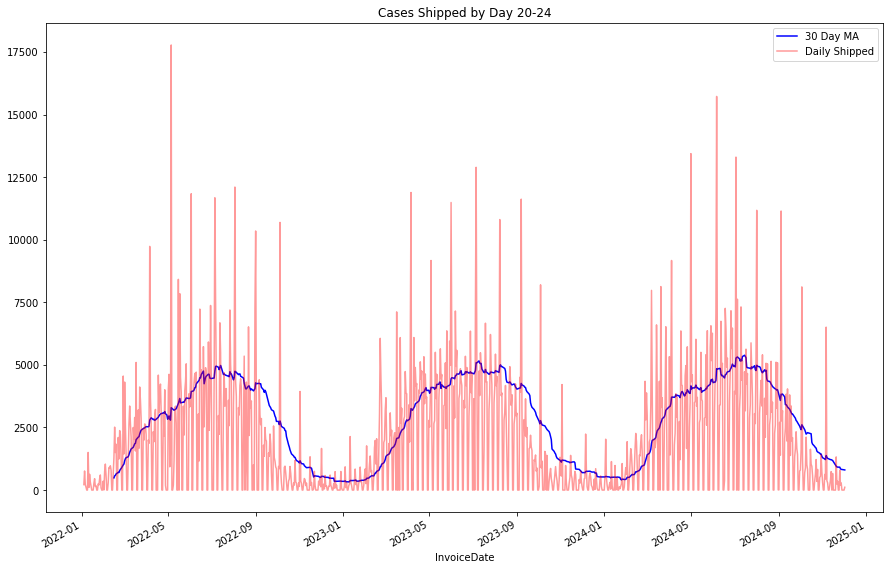

In [42]:
fig,ax=plt.subplots(figsize=(15,10))
# ax=rolling[rolling.QuantityShipped.isin(find)].plot(x=max_year['InvoiceDate'],y=max_year['QuantityShipped'],marker='o')
ax=total_df.groupby('InvoiceDate')['QuantityShipped'].sum().rolling(30).mean().plot(figsize=(15,10),
                                                                                   title='Cases Shipped by Day 20-24',color='blue')
ax=total_df[total_df.InvoiceDueDate.dt.year>=2020].groupby(pd.Grouper(key='InvoiceDate',freq='D'))['QuantityShipped']\
.sum().plot(figsize=(15,10),color='red',alpha=.4)
ax.legend(['30 Day MA','Daily Shipped'])

In [43]:
total_df['Year']=total_df.InvoiceDate.dt.year
from matplotlib.ticker import FormatStrFormatter,StrMethodFormatter
graph=total_df.groupby([pd.Grouper(key='InvoiceDate',freq='M'),'Year'])['Ext Royalty'].sum().reset_index()
graph['Month']=graph.InvoiceDate.dt.strftime('%B')

In [44]:
total_df

CustomerNo InvoiceNo InvoiceType   ShipDate InvoiceDate BillToState  \
0               374   1325936          IN 2021-12-30  2022-01-04          DC   
1               374   1325936          IN 2021-12-30  2022-01-04          DC   
2               374   1326036          IN 2022-01-06  2022-01-07          DC   
3               374   1326036          IN 2022-01-06  2022-01-07          DC   
4               374   1326391          IN 2022-01-20  2022-01-21          DC   
...             ...       ...         ...        ...         ...         ...   
1240678        5036   1487635          IN 2024-08-31  2024-08-31               
1240679        5036   1494689          IN 2024-09-30  2024-09-30               
1240680        5036   1497037          IN 2024-10-31  2024-10-31               
1240681        5038   1494691          IN 2024-09-30  2024-09-30               
1240682        5038   1497038          IN 2024-10-31  2024-10-31               

        InvoiceDueDate ItemCode           ItemCodeDesc ItemType  ...  \
0           2022-02-03     5103       VANILLA CUSTARD         1  ...   
1           2022-02-03     5104         CHOCO CUSTARD         1  ...   
2           2022-02-06     5103       VANILLA CUSTARD         1  ...   
3           2022-02-06     5104         CHOCO CUSTARD         1  ...   
4           2022-02-20     5103       VANILLA CUSTARD         1  ...   
...                ...      ...                    ...      ...  ...   
1240678     2024-09-15    I1000  INTERNATIONAL ROYALTY        1  ...   
1240679     2024-09-30    I1000  INTERNATIONAL ROYALTY        1  ...   
1240680     2024-10-31    I1000  INTERNATIONAL ROYALTY        1  ...   
1240681     2024-09-30    I1000  INTERNATIONAL ROYALTY        1  ...   
1240682     2024-10-31    I1000  INTERNATIONAL ROYALTY        1  ...   

                   CustomerName        City  ARDivisionNo  UDF_ROYALTY_METHOD  \
0        DC RHODE ISLAND AVENUE  Washington            01            STANDARD   
1        DC RHODE ISLAND AVENUE  Washington            01            STANDARD   
2        DC RHODE ISLAND AVENUE  Washington            01            STANDARD   
3        DC RHODE ISLAND AVENUE  Washington            01            STANDARD   
4        DC RHODE ISLAND AVENUE  Washington            01            STANDARD   
...                         ...         ...           ...                 ...   
1240678   PHL BICUTAN SUPERMALL                        01          MANUAL POS   
1240679   PHL BICUTAN SUPERMALL                        01          MANUAL POS   
1240680   PHL BICUTAN SUPERMALL                        01          MANUAL POS   
1240681         PHL UPTOWN MALL                        01          MANUAL POS   
1240682         PHL UPTOWN MALL                        01          MANUAL POS   

        UDF_DISTRIBUTOR        ProductLineDesc             OpenDate  \
0               BAL/BUN                CUSTARD  2005-08-20 00:00:00   
1               BAL/BUN                CUSTARD  2005-08-20 00:00:00   
2               BAL/BUN                CUSTARD  2005-08-20 00:00:00   
3               BAL/BUN                CUSTARD  2005-08-20 00:00:00   
4               BAL/BUN                CUSTARD  2005-08-20 00:00:00   
...                 ...                    ...                  ...   
1240678   INTERNATIONAL  INTERNATIONAL ROYALTY  2024-08-03 00:00:00   
1240679   INTERNATIONAL  INTERNATIONAL ROYALTY  2024-08-03 00:00:00   
1240680   INTERNATIONAL  INTERNATIONAL ROYALTY  2024-08-03 00:00:00   
1240681   INTERNATIONAL  INTERNATIONAL ROYALTY  2024-09-05 00:00:00   
1240682   INTERNATIONAL  INTERNATIONAL ROYALTY  2024-09-05 00:00:00   

         StoreStatus   Weekday  Year  
0               Open   Tuesday  2022  
1               Open   Tuesday  2022  
2               Open    Friday  2022  
3               Open    Friday  2022  
4               Open    Friday  2022  
...              ...       ...   ...  
1240678         Open  Saturday  2024  
1240679         Open    Monday  2024  
124068

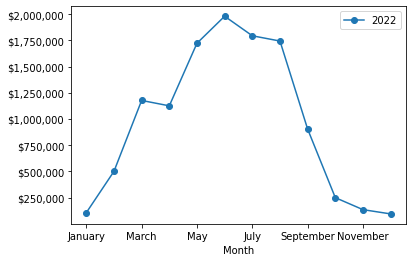

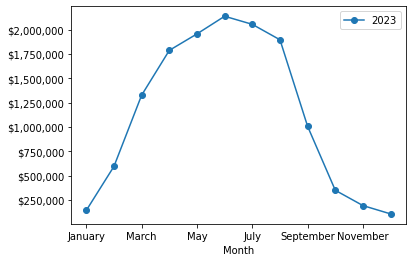

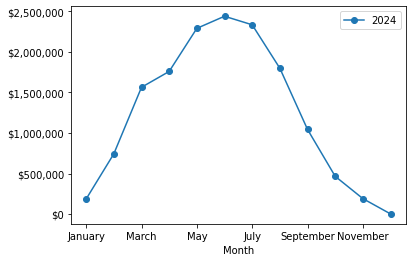

In [45]:
for i in list(enumerate(graph.InvoiceDate.dt.year.unique())):
    ax=graph[graph.Year==i[1]].plot(x='Month',y='Ext Royalty',legend=i[1],marker='o')
    ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
    ax.legend([i[1]])

# Code Below Creates the Invoice Report
- Looking at Product Revenue and Royalties
- Creates Four Pivot tables, two each for Product Revenue and Royalty
- Pivot tables show Product Revenue and Royalty by Week by Shop and by Month by Shop
- The totals for Weekly and Monthly Product revenues should be equal, as well as the Royalty totals
- The totals for these reports will not match what we report on our P/L. That is for several reasons, mostly because these\
  reports are Cash Basis, while our Financial Reports are accraul.
- However, they will be very close to the P/L and at the very least give an indication of how the month is trending
- This report will print out to the folder below and be sent to Bill every Monday
- It's better to wait until Melissa is done her billing, usually around Noon on Mondays before running and sending out

In [66]:
timestamp=date.today().strftime('%m-%d-%y')
state=['PA','NJ','DE','MD']
ytd_royalty=total_df[total_df.InvoiceDate.dt.year==2024].pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate'],
                                                                columns=pd.Grouper(key='InvoiceDate',freq='M'),
                                                                values='Ext Royalty',
                                                                aggfunc='sum',fill_value=0)
weekly=total_df[total_df.InvoiceDate.dt.year==2024].pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate'],
                                                                columns=pd.Grouper(key='InvoiceDate',freq='W'),
                                                                values='Ext Royalty',
                                                                aggfunc='sum',fill_value=0)
ytd_revenue=total_df[total_df.InvoiceDate.dt.year==2024].pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate'],
                                                                columns=pd.Grouper(key='InvoiceDate',freq='M'),
                                                                values='Ext Base Cost',
                                                                aggfunc='sum',fill_value=0)
weekly_revenue=total_df[total_df.InvoiceDate.dt.year==2024].pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate'],
                                                                columns=pd.Grouper(key='InvoiceDate',freq='W'),
                                                                values='Ext Base Cost',
                                                                aggfunc='sum',fill_value=0)
columns=ytd_royalty.columns.strftime('%B')
ytd_royalty.columns=columns
columns=ytd_revenue.columns.strftime('%B')
ytd_revenue.columns=columns
w_columns=list(range(1,len(weekly.columns)+1))
weekly.columns=w_columns
weekly=weekly.add_prefix('Wk')
w_columns_rev=list(range(1,len(weekly_revenue.columns)+1))
weekly_revenue.columns=w_columns_rev
weekly_revenue=weekly_revenue.add_prefix('Wk')
ytd_royalty['Total']=ytd_royalty.sum(axis=1)
weekly['Total']=weekly.sum(axis=1)
ytd_revenue['Total']=ytd_revenue.sum(axis=1)
weekly_revenue['Total']=weekly_revenue.sum(axis=1)
# weekly_revenue.loc['Total']=weekly_revenue.iloc[:,0:].sum(axis=0)
# weekly.loc['Total']=weekly.iloc[:,0:].sum(axis=0)
# ytd_royalty.loc['Total']=ytd_royalty.iloc[:,0:].sum(axis=0)
# ytd_revenue.loc['Total']=ytd_revenue.iloc[:,0:].sum(axis=0)
# ytd_state=ytd_royalty.reset_index().set_index(['CustomerNo','CustomerName'])
# core=ytd_state[ytd_state.BillToState.isin(state)]
# dev=ytd_state[~ytd_state.BillToState.isin(state)]
text1='Ritas Franchise Operations,LLC'
text2='Royalty Revenue Report-By Week'
text3='Royalty Revenue Report-By Month'
text4='Product Revenue Report-By Week'
text5='Product Revenue Report-By Month'
text6='Through '+str(date.today().strftime('%m-%d-%y'))
text7='Source Code: MAS_RFC AR_InvoiceHistoryHeader, AR_Customer, AR_InvoiceHistoryDetail, IM_ProductLine'

writer=pd.ExcelWriter('Bill Royalty 2024 '+str(total_df.InvoiceDate.max().strftime('%m-%d-%y'))+' '+str(timestamp)+'.xlsx',
                      datetime_format='mm/dd/yyyy')
weekly.to_excel(writer, startrow=6,startcol=0,sheet_name='Weekly Royalty')
ytd_royalty.to_excel(writer,startrow=6,startcol=0,sheet_name='Monthly Royalty')
weekly_revenue.to_excel(writer,startrow=6,startcol=0,sheet_name='Weekly Product Revenue')
ytd_revenue.to_excel(writer,startrow=6,startcol=0,sheet_name='Monthly Product Revenue')
workbook=writer.book
worksheet_1=writer.sheets['Weekly Royalty']
worksheet_2=writer.sheets['Monthly Royalty']
worksheet_3=writer.sheets['Weekly Product Revenue']
worksheet_4=writer.sheets['Monthly Product Revenue']
format_1=workbook.add_format({'num_format':'$#,##0.00'})
header_format=workbook.add_format({'bold':True,
                                  'italic':True})
border_format=workbook.add_format({'right':1,'left':1,'bottom':1,'top':1})
date_format=workbook.add_format({'num_format':'m/d/yyyy'})

# Row banding Format(Alternate based on Odd-Even Row Number)
odd_row_format = workbook.add_format({'bg_color': '#E2EFDA'})  # Light Green for odd rows
even_row_format = workbook.add_format({'bg_color': '#FFFFFF'})  # White for even rows


worksheet_1.set_column('A:BZ',12,format_1)
worksheet_1.set_column('B:B',42)
worksheet_1.set_column('D:D',18,date_format)
worksheet_1.write(0,1,text1,header_format)
worksheet_1.write(1,1,text2,header_format)
worksheet_1.write(2,1,text6,header_format)
worksheet_1.write(3,1,text7,header_format)
worksheet_1.conditional_format(xlsxwriter.utility.xl_range(6,0,len(weekly)+6,len(weekly.columns)+3),
                              {'type': 'no_errors', 'format': border_format})
# Apply alternating row colors using a single conditional format
worksheet_1.conditional_format(6, 0, len(weekly) + 6, len(weekly.columns) +3, {
                'type': 'formula',
                'criteria': 'ISEVEN(ROW()-5)',
                'format': even_row_format
            })
worksheet_1.conditional_format(6, 0, len(weekly) + 6, len(weekly.columns) +3, {
                'type': 'formula',
                'criteria': 'ISODD(ROW()-5)',
                'format': odd_row_format
            })


worksheet_1.hide_gridlines(2)
worksheet_1.insert_image('A1','Logo.png')

worksheet_2.set_column('A:BZ',12,format_1)
worksheet_2.set_column('B:B',42)
worksheet_2.set_column('D:D',18,date_format)
worksheet_2.write(0,1,text1,header_format)
worksheet_2.write(1,1,text3,header_format)
worksheet_2.write(2,1,text6,header_format)
worksheet_2.write(3,1,text7,header_format)
worksheet_2.conditional_format(xlsxwriter.utility.xl_range(6,0,len(ytd_royalty)+6,len(ytd_royalty.columns)+3),
                              {'type': 'no_errors', 'format': border_format})
# Apply alternating row colors using a single conditional format
worksheet_2.conditional_format(6, 0, len(ytd_royalty) + 6, len(ytd_royalty.columns) +3, {
                'type': 'formula',
                'criteria': 'ISEVEN(ROW()-5)',
                'format': even_row_format
            })
worksheet_2.conditional_format(6, 0, len(ytd_royalty) + 6, len(ytd_royalty.columns) +3, {
                'type': 'formula',
                'criteria': 'ISODD(ROW()-5)',
                'format': odd_row_format
            })
worksheet_2.hide_gridlines(2)

worksheet_3.set_column('A:BZ',12,format_1)
worksheet_3.set_column('B:B',42)
worksheet_3.set_column('D:D',18,date_format)
worksheet_3.write(0,1,text1,header_format)
worksheet_3.write(1,1,text4,header_format)
worksheet_3.write(2,1,text6,header_format)
worksheet_3.write(3,1,text7,header_format)
worksheet_3.conditional_format(xlsxwriter.utility.xl_range(6,0,len(weekly_revenue)+6,len(weekly_revenue.columns)+3),
                              {'type': 'no_errors', 'format': border_format})
# Apply alternating row colors using a single conditional format
worksheet_3.conditional_format(6, 0, len(weekly_revenue) + 6, len(weekly_revenue.columns) +3, {
                'type': 'formula',
                'criteria': 'ISEVEN(ROW()-5)',
                'format': even_row_format
            })
worksheet_3.conditional_format(6, 0, len(weekly_revenue) + 6, len(weekly_revenue.columns) +3, {
                'type': 'formula',
                'criteria': 'ISODD(ROW()-5)',
                'format': odd_row_format
            })
worksheet_3.hide_gridlines(2)

worksheet_4.set_column('A:BZ',12,format_1)
worksheet_4.set_column('B:B',42)
worksheet_4.set_column('D:D',18,date_format)
worksheet_4.write(0,1,text1,header_format)
worksheet_4.write(1,1,text5,header_format)
worksheet_4.write(2,1,text6,header_format)
worksheet_4.write(3,1,text7,header_format)
worksheet_4.conditional_format(xlsxwriter.utility.xl_range(6,0,len(ytd_revenue)+6,len(ytd_revenue.columns)+3),
                              {'type': 'no_errors', 'format': border_format})
# Apply alternating row colors using a single conditional format
worksheet_4.conditional_format(6, 0, len(ytd_revenue) + 6, len(ytd_revenue.columns) +3, {
                'type': 'formula',
                'criteria': 'ISEVEN(ROW()-5)',
                'format': even_row_format
            })
worksheet_4.conditional_format(6, 0, len(ytd_revenue) + 6, len(ytd_revenue.columns) +3, {
                'type': 'formula',
                'criteria': 'ISODD(ROW()-5)',
                'format': odd_row_format
            })
worksheet_4.hide_gridlines(2)

worksheet_2.insert_image('A1','Logo.png')
worksheet_3.insert_image('A1','Logo.png')
worksheet_4.insert_image('A1','Logo.png')

writer.close()

In [47]:
ytd_royalty.columns

Index(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December', 'Total'],
      dtype='object', name='InvoiceDate')

In [48]:

total_df=total_df[total_df['OpenDate']!='No Open Date']


total_df['OpenDate']=pd.to_datetime(total_df['OpenDate'])
years=[2021,2022,2023,2024]

with pd.ExcelWriter('NSO Case Orders '+str(total_df.InvoiceDate.max().strftime('%m-%d-%y'))+' '+str(timestamp)+'.xlsx',engine='xlsxwriter',datetime_format='mm/dd/yyyy') as writer:
    for i in list(enumerate(years)): 
        nso=total_df[(total_df.OpenDate.dt.year==i[1])&(total_df.InvoiceDate.dt.month<=date.today().month)&(
        total_df.ProductLineDesc.isin(mixes))].pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate','StoreStatus'],
                                                                columns=total_df.InvoiceDate.dt.year,
                                                                 values='QuantityShipped',
                                                                 aggfunc='sum',fill_value=0).reset_index()
        
        nso.to_excel(writer, sheet_name=str(i[1])+' New Shop Orders',startrow=5,startcol=0,index=False)
        wb=writer.book
        vol_format=wb.add_format({'num_format':'#,##0.0',
                                 'align':'center',
                                 'valign':'vcenter'})
        border_format=wb.add_format({'top':2,'bottom':2,'left':2,'right':2})
        align=wb.add_format({'align':'center',
                            'valign':'vcenter'})
        ws=writer.sheets[str(i[1])+' New Shop Orders']
        title='Ritas Franchise Company,LLC'
        title1=str(i[1])+' New Shop Mix & Custard Case Orders'
        title2='Case Orders thru '+(str(total_df.InvoiceDate.max().strftime('%m/%d/%y')))
        title3='Source Code: Invoice History Detail'
        header_format=wb.add_format({'bold':True,
                                    'italic':True})
        # Row banding Format(Alternate based on Odd-Even Row Number)
        odd_row_format = wb.add_format({'bg_color': '#FFFFFF'})  # White for odd rows
        even_row_format = wb.add_format({'bg_color': '#E2EFDA'})  # Light Green for even rows
        
        ws.conditional_format(xlsxwriter.utility.xl_range(5,0,len(nso)+5,len(nso.columns)-1),
                              {'type': 'no_errors', 'format': border_format})
        
        # Apply alternating row colors using a single conditional format
        ws.conditional_format(5, 0, len(nso) + 5, len(nso.columns) -1, {
                'type': 'formula',
                'criteria': 'ISEVEN(ROW()-5)',
                'format': even_row_format
            })
        ws.conditional_format(5, 0, len(nso) + 5, len(nso.columns) -1, {
                'type': 'formula',
                'criteria': 'ISODD(ROW()-5)',
                'format': odd_row_format
            })
        ws.write(0,1,title,header_format)
        ws.write(1,1,title1,header_format)
        ws.write(2,1,title2,header_format)
        ws.write(3,1,title3,header_format)
        ws.set_column('A:H',12,align)
        ws.set_column('B:B',45,align)
        ws.set_column('E:E',18.2,align)
        ws.set_column('F:I',12,vol_format)
        ws.hide_gridlines(2)
        ws.insert_image('A1','Logo.png')
       

C:\Users\jharned\AppData\Local\Temp\ipykernel_24456\1673014992.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['OpenDate']=pd.to_datetime(total_df['OpenDate'])


In [49]:
pd.set_option('display.max_columns', 500)
total_df[(total_df.ItemCodeDesc=='VANILLA CUSTARD ')]\
.groupby(pd.Grouper(key='InvoiceDate',freq='Y'))['UDF_STD_UNIT_PRICE'].agg(['mean','median','max','min'])

mean  median    max    min
InvoiceDate                                 
2022-12-31   68.753119   68.99  68.99  62.38
2023-12-31   72.846356   74.10  74.10  68.99
2024-12-31   70.901744   70.89  71.26  70.89

In [50]:
# text1='Ritas Franchise Operations,LLC'
# text2='Vanilla Custrard Orders through July'
# text3='For Years 2023 and 2024'
# text4='Source Code: MAS_RFC AR_InvoiceHistoryHeader, AR_Customer, AR_InvoiceHistoryDetail, IM_ProductLine'
# writer2=pd.ExcelWriter('Vanilla Custard Orders July Only.xlsx',datetime_format='mm/dd/yyyy')
# total_df[(total_df.InvoiceDate.dt.year>=2023)&(total_df.InvoiceDate.dt.month<=7)]\
# .pivot_table(index=['CustomerNo','CustomerName','BillToState','OpenDate'],
#                                                                 columns=[total_df.InvoiceDate.dt.year,'ItemCodeDesc'],
#                                                                 values='QuantityShipped',
#                                                                 aggfunc='sum',fill_value=0).filter(regex='VANILLA CUSTARD')\
# .to_excel(writer2, sheet_name='July Orders Comp',startrow=5,startcol=0)
# workbook=writer2.book
# worksheet_1=writer2.sheets['July Orders Comp']
# format_1=workbook.add_format({'num_format':'#,##0.0'})
# header_format=workbook.add_format({'bold':True,
#                                   'italic':True})
# worksheet_1.set_column('A:AZ',12,format_1)
# worksheet_1.set_column('B:B',42)
# worksheet_1.write(0,1,text1,header_format)
# worksheet_1.write(1,1,text2,header_format)
# worksheet_1.write(2,1,text3,header_format)
# worksheet_1.write(3,1,text4,header_format)
# worksheet_1.insert_image('A1','Logo.png')
# writer2.close()

In [51]:
# total_df[(total_df.InvoiceDate.dt.year>=2023)&(total_df.InvoiceDate.dt.month<=7)&(total_df.ProductLineDesc.isin(mixes))]\
# .pivot_table(index=['ItemCodeDesc'],columns=[total_df.InvoiceDate.dt.year],values='UDF_STD_UNIT_PRICE',
#                                                                 aggfunc='mean',fill_value=0).to_excel('Test2.xlsx')

In [52]:
# mix=total_df[(total_df.InvoiceDate.dt.year>=2023)&(total_df.InvoiceDate.dt.month<=7)&(total_df.ProductLineDesc.isin(mixes))]\
# .pivot_table(index=['ItemCodeDesc'],columns=[total_df.InvoiceDate.dt.year],values='QuantityShipped',
#                                                                 aggfunc='sum',fill_value=0).apply(lambda x:x/sum(x))\
# .reset_index()
# median=total_df[(total_df.InvoiceDate.dt.year>=2023)&(total_df.InvoiceDate.dt.month<=7)&(total_df.ProductLineDesc.isin(mixes))]\
# .pivot_table(index=['ItemCodeDesc'],columns=[total_df.InvoiceDate.dt.year],values='UDF_STD_UNIT_PRICE',
#                                                                 aggfunc='median',fill_value=0).reset_index()
# mix.merge(median,on='ItemCodeDesc',suffixes=['_Mix','_Median']).to_excel('Test3.xlsx',index=False)

In [53]:
total_df['Month']=total_df.InvoiceDate.dt.strftime('%B')
total_df['Month_Num']=total_df.InvoiceDate.dt.month

C:\Users\jharned\AppData\Local\Temp\ipykernel_24456\22577313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['Month']=total_df.InvoiceDate.dt.strftime('%B')
C:\Users\jharned\AppData\Local\Temp\ipykernel_24456\22577313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['Month_Num']=total_df.InvoiceDate.dt.month


In [54]:
yearly=total_df[total_df.InvoiceDate.dt.year>=2023]\
.groupby(['Month_Num','Month',total_df.InvoiceDate.dt.year])['Ext Royalty'].sum().reset_index().sort_values(by='Month_Num')

In [55]:
yearly

Month_Num      Month  InvoiceDate   Ext Royalty
0           1    January         2023  1.436604e+05
1           1    January         2024  1.841149e+05
2           2   February         2023  5.960525e+05
3           2   February         2024  7.409386e+05
4           3      March         2023  1.327119e+06
5           3      March         2024  1.560414e+06
6           4      April         2023  1.787328e+06
7           4      April         2024  1.754487e+06
8           5        May         2023  1.956606e+06
9           5        May         2024  2.279894e+06
11          6       June         2024  2.410059e+06
10          6       June         2023  2.137925e+06
12          7       July         2023  2.054799e+06
13          7       July         2024  2.327771e+06
14          8     August         2023  1.896092e+06
15          8     August         2024  1.790920e+06
16          9  September         2023  1.006238e+06
17          9  September         2024  1.040666e+06
18         10    October         2023  3.500335e+05
19         10    October         2024  4.643601e+05
20         11   November         2023  1.931017e+05
21         11   November         2024  1.898556e+05
22         12   December         2023  1.052546e+05
23         12   December         2024  2.956370e+03

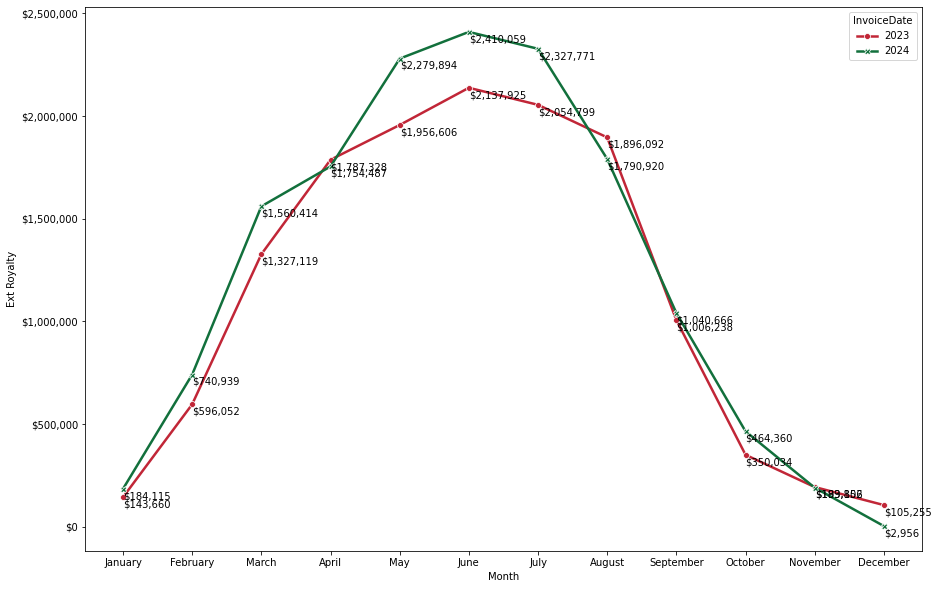

In [56]:
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(data=yearly, x='Month',y='Ext Royalty',hue='InvoiceDate',palette=['#C12637','#12703C'],
            markers=True,dashes=False,linewidth=2.5,style='InvoiceDate')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
for x,y in zip(yearly.Month,yearly['Ext Royalty']):
    plt.text(x=x, y=y-50000, s='${:,.0f}'.format(y))

In [57]:
import plotly.graph_objects as go

# Example DataFrame setup (assuming yearly is already defined as a DataFrame)
# yearly = pd.DataFrame(...)  # your DataFrame with Month, Ext Royalty, InvoiceDate columns

# Initialize the Plotly figure
fig = go.Figure()

# Loop through unique InvoiceDate to create traces for each hue
for invoice_date in yearly['InvoiceDate'].unique():
    filtered_data = yearly[yearly['InvoiceDate'] == invoice_date]
    
    # Add line trace for each InvoiceDate
    fig.add_trace(go.Scatter(
        x=filtered_data['Month'],
        y=filtered_data['Ext Royalty'],
        mode='lines+markers+text',
        name=str(invoice_date),  # Legend entry
        text=[f'${value:,.0f}' for value in filtered_data['Ext Royalty']],  # Display values as text
        textposition='bottom center',  # Position text below the markers
        line=dict(width=2.5),
        marker=dict(size=8)
    ))

# Customize layout
fig.update_layout(
    title='Ext Royalty by Month',
    xaxis_title='Month',
    yaxis_title='Ext Royalty',
    yaxis_tickprefix='$',  # Add dollar sign prefix
    yaxis_tickformat=',',  # Format y-axis ticks with commas
    width=1000,
    height=900,
)

# Show the interactive plot
fig.show()

In [58]:
product_orders=total_df[total_df.InvoiceDate.dt.year>=2023]\
.groupby(['Month_Num','Month',total_df.InvoiceDate.dt.year])['Ext Base Cost'].sum().reset_index().sort_values(by='Month_Num')

product_orders=product_orders.rename(columns={'InvoiceDate':'Year'})
fig=go.Figure()

for i in product_orders.Year.unique():
    filtered_products=product_orders[product_orders.Year==i]
    
    fig.add_trace(go.Scatter(
        x=filtered_products.Month,
        y=filtered_products['Ext Base Cost'],
        mode='lines+markers+text',
        name=str(i),
        line=dict(width=2.5),
        marker=dict(size=8),
        text=[f'${j:,.0f}' for j in filtered_products['Ext Base Cost']],
        textposition='top center',
        textfont=dict(size=10)
    ))
    
fig.update_layout(title=dict(text='Product Revenue By Month',font=dict(size=16)),
                    xaxis_title='Month',
                    yaxis_title='Product Revenue',
                    yaxis_tickprefix='$',
                    yaxis_tickformat=',',
                    height=1000,
                    width=900
                     )
fig.show()


In [59]:
product_orders

Month_Num      Month  Year  Ext Base Cost
0           1    January  2023   3.700061e+05
1           1    January  2024   4.323006e+05
2           2   February  2023   1.531773e+06
3           2   February  2024   1.777312e+06
4           3      March  2023   3.458410e+06
5           3      March  2024   3.646227e+06
6           4      April  2023   4.441330e+06
7           4      April  2024   4.115948e+06
8           5        May  2023   4.931016e+06
9           5        May  2024   5.269264e+06
11          6       June  2024   5.373180e+06
10          6       June  2023   5.385523e+06
12          7       July  2023   4.958829e+06
13          7       July  2024   5.260839e+06
14          8     August  2023   4.617839e+06
15          8     August  2024   4.007999e+06
16          9  September  2023   2.403975e+06
17          9  September  2024   2.405797e+06
18         10    October  2023   8.674094e+05
19         10    October  2024   1.078202e+06
20         11   November  2023   4.634409e+05
21         11   November  2024   4.113053e+05
22         12   December  2023   3.343794e+05
23         12   December  2024   6.545060e+03

In [60]:
fig = go.Figure(data=go.Scatter(x=[1, 2, 3, 4], y=[10, 15, 13, 17]))

fig.update_layout(
    title="Customized Layout Example",
    xaxis=dict(title="X Axis", tickformat=".1f"),
    yaxis=dict(title="Y Axis", range=[0, 20]),
    showlegend=False,
    paper_bgcolor="lightblue",
    plot_bgcolor="white",
    margin=dict(l=50, r=50, t=100, b=50),
    annotations=[dict(x=3, y=15, text="Highlight", showarrow=True, arrowhead=1)]
)

fig.show()


In [61]:
total_df[(total_df.InvoiceDate.dt.year>=2023)&(total_df.InvoiceDate.dt.month<=10)&(total_df.ProductLineDesc.isin(mixes))]\
.pivot_table(index=['ItemCodeDesc'],columns=[total_df.InvoiceDate.dt.year],values='UDF_STD_UNIT_PRICE',
                                                                aggfunc='median',fill_value=0)

InvoiceDate                       2023    2024
ItemCodeDesc                                  
2.5 GAL CHOCO CUST CREDIT        36.79   35.63
2.5 GAL VANILLA CUST CREDIT      37.05   35.45
BANANA MIX                       53.24   59.05
BIRTHDAY CAKE MIX                61.98   68.76
BLUEBERRY/BLUE RASP              51.52   55.07
CANTALOUPE MIX                   66.53   80.23
CHEESECAKE MIX                   65.52   81.75
CHERRY MIX                       63.36   68.56
CHOCO CUSTARD                    73.57   71.26
CHOCOLATE MIX                    55.97   61.21
CITRUS BLAST MIX                 59.39    0.00
COCONUT CREAM MIX                48.65   57.83
COOKIES N' CREAM MIX             51.11   56.56
COTTON CANDY MIX                 68.33   69.12
CY POWDER CHOCO CUSTARD           0.00  133.51
CY POWDER VANILLA CUSTARD         0.00  132.20
DR.PEPPER MIX                   109.00  118.30
FLORIDA ORANGE MIX               68.53   98.83
GRAPE MIX                        95.95   95.95
GREEN APPLE                      57.80   63.22
GUAVA PASSION FRUIT MIX -4/1 G   61.29    0.00
GUMMY BEAR MIX                   61.56   61.56
ISLAND FUSION MIX                68.48   79.43
JUICY PEAR MIX                   63.53   68.27
KEY LIME MIX                     52.10   59.17
KLEINS CHOCO CUSTARD              0.00    0.00
KLEINS VANILLA CUSTARD            0.00    0.00
KOOL AID MIX                      0.00   54.16
LEMON BASE                       44.48   51.26
MANGO MIX                        57.90   61.88
MINT CHOC CHIP CRM MIX           51.03   60.54
NERDS MIX                         0.00   56.12
NEW GEORGIA PEACH MIX            69.85   76.60
OATLY VANILLA SOFT SERVE         48.26    0.00
OCEAN SPLASH                    110.59  125.91
PINA COLADA MIX                  47.92   56.63
PINEAPPLE MIX                    61.22   68.03
PUMPKIN MIX                      70.98   84.30
RASPBERRY MIX                   124.39  119.20
ROOT BEER MIX                    49.47   58.34
S'MORES MIX                      66.80   74.32
SOUR PATCH KIDS MIX              60.44   68.26
SOUR PATCH WATERMELON             0.00   82.98
STRAWBERRY MIX                   59.22   63.17
SWEDISH FISH MIX                 61.40   66.40
TANGERINE MIX                    61.94    0.00
TROPICAL PUNCH MIX               74.15   74.15
UNICORN MIX                     109.34  125.02
VANILLA CUSTARD                  74.10   70.89
VANILLA MIX                      48.76   56.53
WATERMELON MIX                   49.19   54.77
WILD BLACK CHERRY MIX            67.24   72.22

In [62]:
# total_df['Year']=total_df.InvoiceDate.dt.year
# total_df['Month']=total_df.InvoiceDate.dt.strftime('%B')
# hist_royalty=total_df.pivot_table(index=['Year'],
#                                                                 columns='Month',
#                                                                 values='Ext Royalty',
#                                                                 aggfunc='sum',fill_value=0)

# hist_royalty.to_excel('Historical Royalty.xlsx')

In [63]:
total_df.InvoiceDate.max()

Timestamp('2024-12-02 00:00:00')

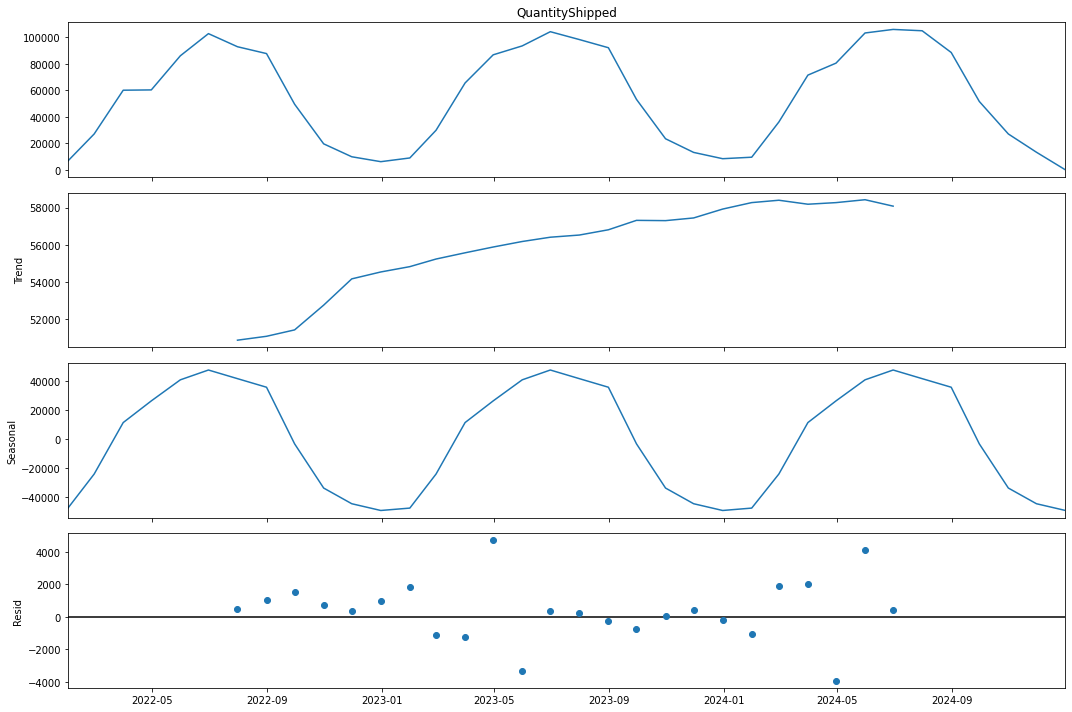

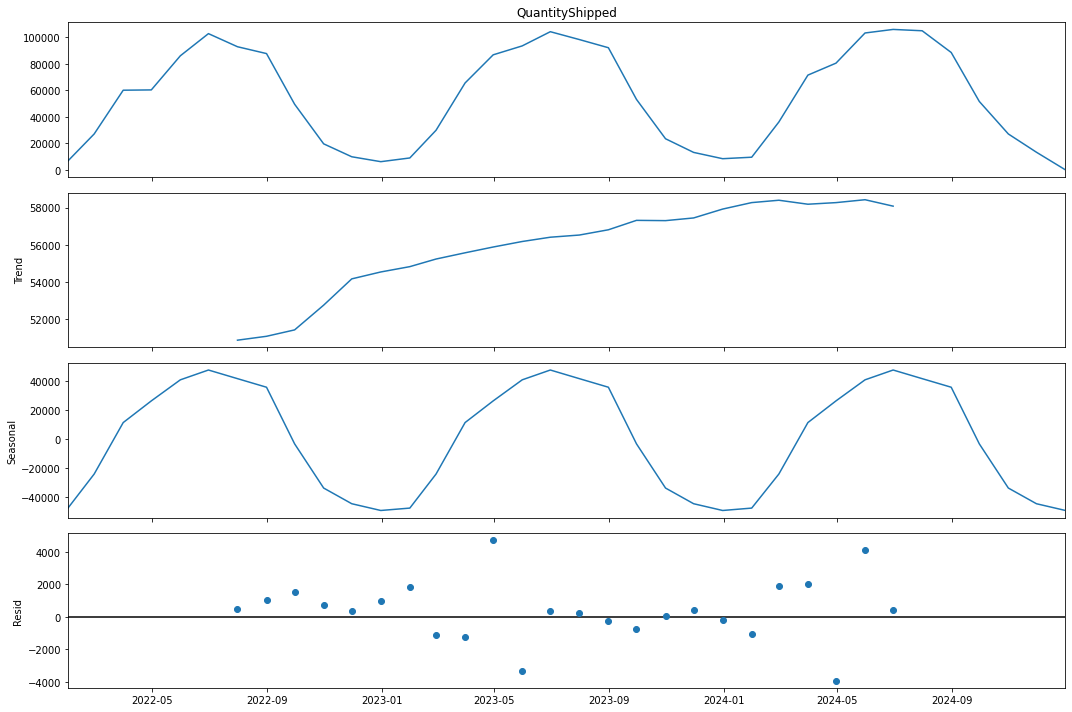

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose
season=total_df.groupby(pd.Grouper(key='InvoiceDate',freq='M'))['QuantityShipped'].sum().reset_index()
season=season.set_index('InvoiceDate')
results=seasonal_decompose(season.QuantityShipped,model='additive')
plt.rcParams.update({'figure.figsize': (15,10)})
results.plot()

<Axes: xlabel='InvoiceDate'>

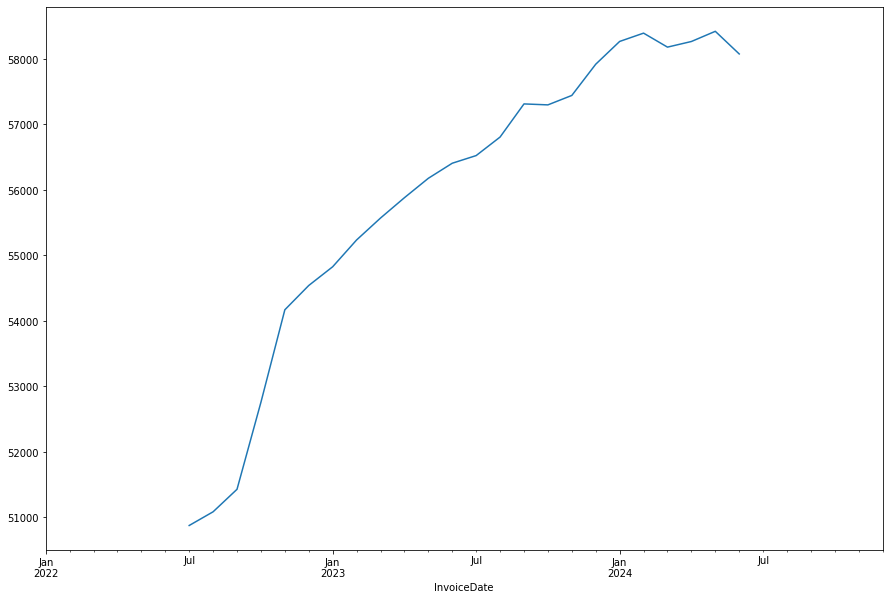

In [65]:
results.trend.plot()